## Overview
This notebook is used to generate various test vectors to support FALCON Digital Signal Processing unit tests. Vectors include: Finite Impulse Response (FIR) filter coefficients, raw complex input data, and raw complex output data.

## Constants
This notebook supports configurable behavior through environment variables, which in turn modify the notebook-level constants specified here.

In [2]:
import logging
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import os
from scipy import signal
import struct

In [13]:
FILTER_ORDER_STR = os.environ.get('FILTER_ORDER', '128')
NUM_INPUT_TONES_STR = os.environ.get('NUM_INPUT_TONES', '4')
INPUT_SAMPLE_RATE_STR = os.environ.get('INPUT_SAMPLE_RATE', '1000000')
NUM_OUTPUT_SAMPLES_STR = os.environ.get('NUM_OUTPUT_SAMPLES', '1000000')
VERBOSE_LOGGING_STR = os.environ.get('VERBOSE', '0')
OUTPUT_FILE_BASE_NAME = os.environ.get('OUT_FILE_NAME', 'fir_filter_test_vector')

# convert from the string environment variables to other, more convenient, representations
FILTER_ORDER = int(FILTER_ORDER_STR) + 1
NUM_TONES = int(NUM_INPUT_TONES_STR)
INPUT_SAMPLE_RATE = np.array([INPUT_SAMPLE_RATE_STR], dtype=np.float64)
NUM_OUTPUT_SAMPLES = int(NUM_OUTPUT_SAMPLES_STR)

INPUT_VEC_FILE_NAME = OUTPUT_FILE_BASE_NAME + "_x.bin"
OUTPUT_VEC_FILE_NAME = OUTPUT_FILE_BASE_NAME + "_y.bin"
FILTER_COEFFS_FILE_NAME = OUTPUT_FILE_BASE_NAME + ".filter_coeffs.txt"

VERBOSE_LOGGING = True
if VERBOSE_LOGGING_STR is not "1":
    VERBOSE_LOGGING = False

## Logging
Use the Python *logging* module for basic logging. Configure the logging level based on the provided command-line arguments.

In [14]:
logging_level = logging.INFO
if VERBOSE_LOGGING:
    logging_level = logging.DEBUG
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging_level)

In [17]:
logging.info("####################")
logging.info("# FILTER_ORDER            = %u" % (FILTER_ORDER - 1))
logging.info("# NUM_TONES               = %u" % (NUM_TONES))
logging.info("# INPUT_SAMPLE_RATE       = %f" % (INPUT_SAMPLE_RATE))
logging.info("# NUM_OUTPUT_SAMPLES      = %u" % (NUM_OUTPUT_SAMPLES))
logging.info("# INPUT_FILE_NAME         = %s" % (INPUT_VEC_FILE_NAME))
logging.info("# OUTPUT_FILE_NAME        = %s" % (OUTPUT_VEC_FILE_NAME))
logging.info("# FILTER_COEFFS_FILE_NAME = %s" % (FILTER_COEFFS_FILE_NAME))
logging.info("####################")

INFO:####################
INFO:# FILTER_ORDER            = 128
INFO:# NUM_TONES               = 4
INFO:# INPUT_SAMPLE_RATE       = 1000000.000000
INFO:# NUM_OUTPUT_SAMPLES      = 1000000
INFO:# INPUT_FILE_NAME         = fir_filter_test_vector_x.bin
INFO:# OUTPUT_FILE_NAME        = fir_filter_test_vector_y.bin
INFO:# FILTER_COEFFS_FILE_NAME = fir_filter_test_vector.filter_coeffs.txt
INFO:####################


## Design a Low Pass Filter
Create a basic FIR that filters out all signals that are more than 20% away from the center frequency. A single tone will be inserted within the passband with other tones outside the passband to demonstrate that the filtering works as intended.

INFO:Input Sample Rate:1000000 Hz
INFO:Cutoff freq:200000.00 Hz
INFO:Filter order:129 delay:64
INFO:Write filter coefficients to fir_filter_test_vector.filter_coeffs.txt


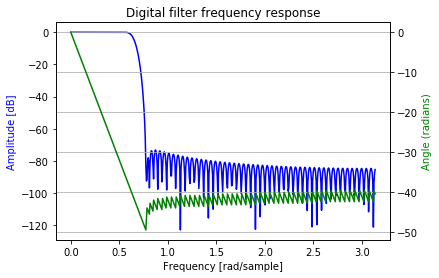

In [18]:
CUTOFF_FREQ_RATIO = 0.2
CUTOFF_FREQ = CUTOFF_FREQ_RATIO * INPUT_SAMPLE_RATE
FILTER_DELAY = int((FILTER_ORDER - 1) / 2)

logging.info("Input Sample Rate:%d Hz" % (INPUT_SAMPLE_RATE))
logging.info("Cutoff freq:%.2f Hz" % (CUTOFF_FREQ))
logging.info("Filter order:%u delay:%u" % (FILTER_ORDER, FILTER_DELAY))

filter_coeffs = signal.firls(FILTER_ORDER, [0, CUTOFF_FREQ_RATIO, CUTOFF_FREQ_RATIO * 1.1, 1.0], [1.0, 1.0, 0.0, 0.0])
filter_coeffs = filter_coeffs * signal.kaiser(FILTER_ORDER, beta=5)

filter_coeffs_file = open(FILTER_COEFFS_FILE_NAME, 'w')
for coeff in filter_coeffs:
    filter_coeffs_file.write("%0.12f %0.12f\n" % (coeff.real, coeff.imag))

filter_coeffs_file.close()

logging.info("Write filter coefficients to %s" % (FILTER_COEFFS_FILE_NAME))

# visualize the filter response
w, h = signal.freqz(filter_coeffs)
fig = plt.figure()
plt.title('Digital filter frequency response')
ax1 = fig.add_subplot(111)

plt.plot(w, 20 * np.log10(abs(h)), 'b')
plt.ylabel('Amplitude [dB]', color='b')
plt.xlabel('Frequency [rad/sample]')

ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h))
plt.plot(w, angles, 'g')
plt.ylabel('Angle (radians)', color='g')
plt.grid()
plt.axis('tight')
plt.show()

## Create a Complex Sinusoid

In [21]:
SIGNAL_SCALE = 2048
NUM_INPUT_SAMPLES = NUM_OUTPUT_SAMPLES + FILTER_ORDER

t = np.arange(0, NUM_INPUT_SAMPLES, dtype=np.float64)
logging.info("Time (t) vector requires %.3f mega bytes" % (t.nbytes / 1024.0 / 1024.0))

# create a single tone within the passband
x = SIGNAL_SCALE * np.exp(1j * 2 * np.pi * t * float(CUTOFF_FREQ * 0.1/INPUT_SAMPLE_RATE))

num_negative_tones = np.random.randint(0, NUM_TONES)
num_positive_tones = NUM_TONES - num_negative_tones

# add negative freq tones outside the passband
for tone_idx in range(num_negative_tones):
    
    tone_freq = np.random.randint(-1 * (INPUT_SAMPLE_RATE / 2), -1 * CUTOFF_FREQ * 1.1)
    
    temp_x = SIGNAL_SCALE * np.exp(1j * 2 * np.pi * t * float(tone_freq/INPUT_SAMPLE_RATE))
    temp_x = temp_x.astype(np.complex64)
    x += temp_x

# add positive freq tones outside the passband
for tone_idx in range(num_positive_tones):
    
    tone_freq = np.random.randint(CUTOFF_FREQ * 1.1, INPUT_SAMPLE_RATE / 2)
    
    temp_x = SIGNAL_SCALE * np.exp(1j * 2 * np.pi * t * float(tone_freq/INPUT_SAMPLE_RATE))
    temp_x = temp_x.astype(np.complex64)
    x += temp_x

# add a small amount of noise
noise_power = 0.001 * INPUT_SAMPLE_RATE / 2
x += np.random.normal(scale=np.sqrt(noise_power), size=t.shape)

logging.info("Input (x) vector created with %u tones outside passband" % (NUM_TONES * 2))

INFO:Time (t) vector requires 7.630 mega bytes
INFO:Input (x) vector created with 8 tones outside passband


Plot the unfiltered vector

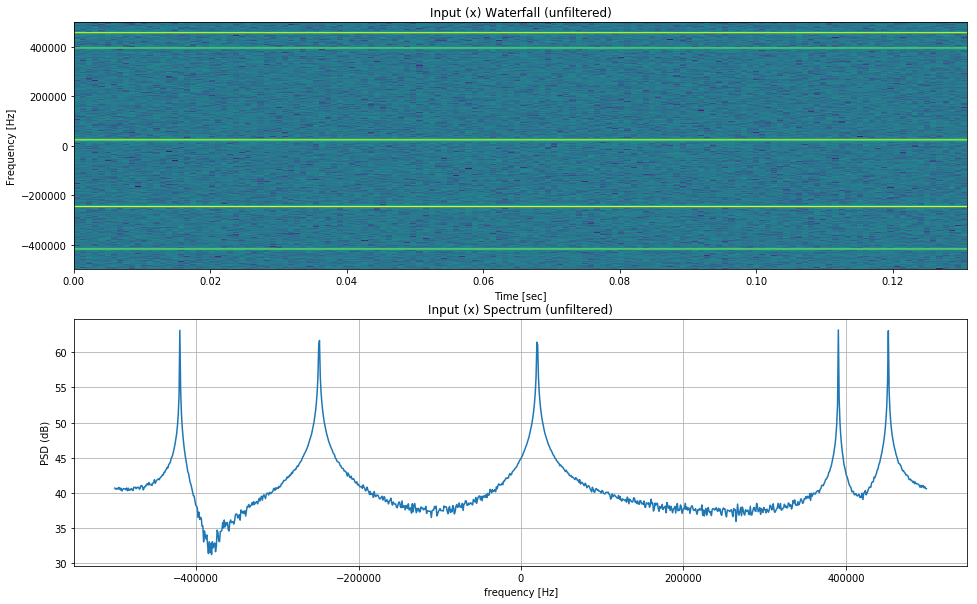

In [22]:
FFT_SIZE = 1024
NUM_FFTS = 128
plt.figure(figsize=(16, 10))

plt.subplot(2,1,1)
Pxx, freqs, bins, im = plt.specgram(x[:FFT_SIZE*NUM_FFTS], NFFT=FFT_SIZE, Fs=INPUT_SAMPLE_RATE)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Input (x) Waterfall (unfiltered)')

plt.subplot(2,1,2)

psd = np.abs(np.fft.fftshift(np.fft.fft(x[:FFT_SIZE], FFT_SIZE)))
psd = 10 * np.log10(psd)
freqs = np.arange(-1 * (INPUT_SAMPLE_RATE / 2), (INPUT_SAMPLE_RATE / 2), INPUT_SAMPLE_RATE / FFT_SIZE, dtype=np.float64)
plt.plot(freqs, psd)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD (dB)')
plt.title('Input (x) Spectrum (unfiltered)')
plt.grid(True)

Now filter the vector using the computed FIR

In [23]:
y = signal.lfilter(filter_coeffs, 1.0, x)

Plot the filtered vector

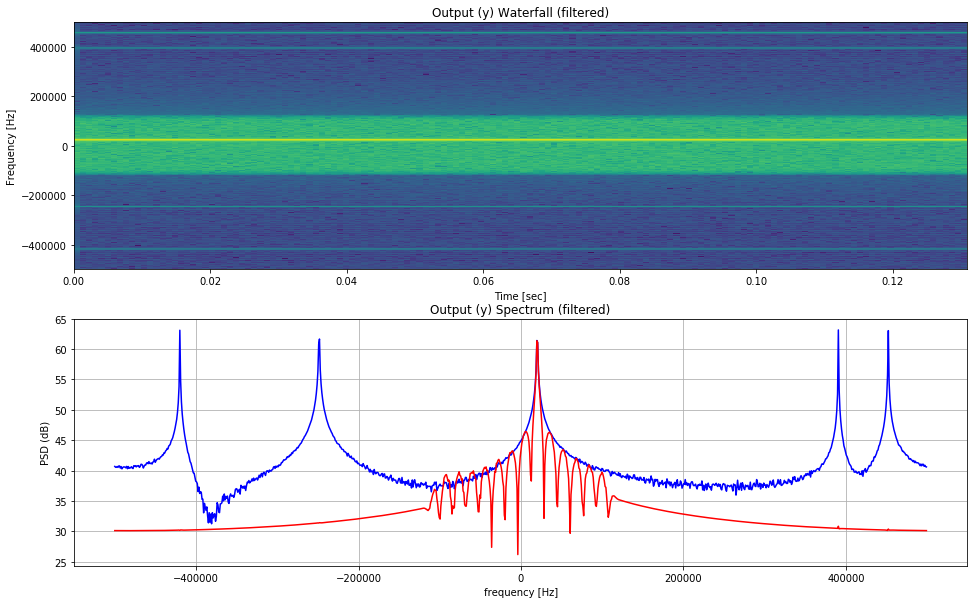

In [24]:
FFT_SIZE = 1024
NUM_FFTS = 128
plt.figure(figsize=(16, 10))

plt.subplot(2,1,1)
Pxx, freqs, bins, im = plt.specgram(y[:FFT_SIZE*NUM_FFTS], NFFT=FFT_SIZE, Fs=INPUT_SAMPLE_RATE)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Output (y) Waterfall (filtered)')

plt.subplot(2,1,2)

psd = np.abs(np.fft.fftshift(np.fft.fft(x[:FFT_SIZE], FFT_SIZE)))
psd = 10 * np.log10(psd)
freqs = np.arange(-1 * (INPUT_SAMPLE_RATE / 2), (INPUT_SAMPLE_RATE / 2), INPUT_SAMPLE_RATE / FFT_SIZE, dtype=np.float64)
plt.plot(freqs, psd, 'b')

psd = np.abs(np.fft.fftshift(np.fft.fft(y[:FFT_SIZE*NUM_FFTS], FFT_SIZE)))
psd = 10 * np.log10(psd)
freqs = np.arange(-1 * (INPUT_SAMPLE_RATE / 2), (INPUT_SAMPLE_RATE / 2), INPUT_SAMPLE_RATE / FFT_SIZE, dtype=np.float64)
plt.plot(freqs, psd, 'r')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD (dB)')
plt.title('Output (y) Spectrum (filtered)')
plt.grid(True)

### Save the Input and Output Vectors

In [25]:
# save the input "x" vector file
input_vec_file = open(INPUT_VEC_FILE_NAME, 'wb')

num_samples_processed = 0
for val in x:
    
    real_val = int(val.real)
    imag_val = int(val.imag)
    
    # pack as little endian format using shorts (int16_t)
    input_vec_file.write(struct.pack('<2h', real_val, imag_val))
    
    num_samples_processed += 1
    
input_vec_file.close()

# save the output "y" vector file
output_vec_file = open(OUTPUT_VEC_FILE_NAME, 'wb')

num_samples_processed = 0
for val in y:
    
    real_val = int(val.real)
    imag_val = int(val.imag)
    
    # pack as little endian format using shorts (int16_t)
    output_vec_file.write(struct.pack('<2h', real_val, imag_val))
    
    num_samples_processed += 1
    
output_vec_file.close()